# Rare Variants

TODO: Remove WGS derived from fibroblasts? They have a lot of extra variants.

In [52]:
import copy
import datetime as dt
import glob
import os
import re
import subprocess
import urllib2

import cdpybio as cpb
from ipyparallel import Client
from scipy.stats import fisher_exact
import matplotlib.gridspec as gridspec
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyencodetools as pet
import pybedtools as pbt
import scipy
import scipy.stats as stats
import seaborn as sns
import socket
import statsmodels.stats.multitest as smm
import vcf as pyvcf

import cardipspy as cpy
import ciepy

%matplotlib inline
%load_ext rpy2.ipython

dy_name = 'rare_variants'

import socket
if socket.gethostname() == 'fl-hn1' or socket.gethostname() == 'fl-hn2':
    dy = os.path.join(ciepy.root, 'sandbox', dy_name)
    cpy.makedir(dy)
    pbt.set_tempdir(dy)
    
outdir = os.path.join(ciepy.root, 'output', dy_name)
cpy.makedir(outdir)

private_outdir = os.path.join(ciepy.root, 'private_output', dy_name)
cpy.makedir(private_outdir)

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [2]:
tg = pd.read_table(cpy.gencode_transcript_gene, index_col=0, 
                   header=None, squeeze=True)
gene_info = pd.read_table(cpy.gencode_gene_info, index_col=0)
genes = pbt.BedTool(cpy.gencode_gene_bed)
fn = os.path.join(ciepy.root, 'output', 'input_data', 'rsem_tpm.tsv')
tpm = pd.read_table(fn, index_col=0)

cnvs = pd.read_table(os.path.join(ciepy.root, 'output', 'input_data',
                                  'cnvs.tsv'), index_col=0)
fn = os.path.join(ciepy.root, 'output', 'input_data', 'wgs_metadata.tsv')
wgs_meta = pd.read_table(fn, index_col=0, squeeze=True)
fn = os.path.join(ciepy.root, 'output', 'input_data', 'rnaseq_metadata.tsv')
rna_meta = pd.read_table(fn, index_col=0)
rna_meta = rna_meta[rna_meta.in_eqtl]
fn = os.path.join(ciepy.root, 'output', 'input_data', 'subject_metadata.tsv')
subject_meta = pd.read_table(fn, index_col=0)

wgs_to_rna = pd.Series(rna_meta.index, index=rna_meta.wgs_id)

In [3]:
fn = os.path.join(outdir, 'promoter_regions.bed')
if not os.path.exists(fn):
    promoter_regions = cpb.gencode.make_promoter_bed(cpy.gencode_gtf, merge_by_gene=True,
                                                     up=2000, down=200, out=fn)
else:
    promoter_regions = pbt.BedTool(fn)
    
gene_to_region = {}
for r in promoter_regions:
    k = r.name.split('_')[0]
    gene_to_region[k] = gene_to_region.get(k, []) + ['{}:{}-{}'.format(r.chrom, r.start, r.end)]

In [128]:
t = promoter_regions.to_dataframe()
t.chrom = t.chrom.apply(lambda x: x[3:])
# bcftools needs a one-based inclusive bed file.
s = '\n'.join(t.chrom + '\t' + (t.start + 1).astype(str) + '\t' + 
              t.end.astype(str)) + '\n'
bt = pbt.BedTool(s, from_string=True)

In [129]:
vcfs = ['CARDIPS_chr{}_phased.vcf.gz'.format(x) for x in range(1, 23)]
vcfs = [os.path.join('/projects/CARDIPS/pipeline/WGS/mergedVCF/phased_20151214/', x) for x in vcfs]
for vcf in vcfs:
    out = os.path.split(vcf)[1].split('.')[0] + '_promoter_variants.vcf'
    out = os.path.join(private_outdir, out)
    c = 'bcftools view -Ov -R {} {} > {}'.format(bt.fn, vcf, out)
    subprocess.check_call(c, shell=True)

In [71]:
log_tpm = np.log10(tpm + 1)
# We'll limit to the eQTL samples so we have one sample per subject and we know
# we have WGS data.
log_tpm_f = log_tpm[rna_meta[rna_meta.in_eqtl].index]
log_tpm_f = log_tpm_f[(log_tpm_f != 0).sum(axis=1) >= (log_tpm_f.shape[1] * 0.5)]
log_tpm_c = (log_tpm_f.T - log_tpm_f.mean(axis=1)).T
log_tpm_z = (log_tpm_c.T / log_tpm_c.std(axis=1)).T
chroms = ['chr{}'.format(x) for x in range(1, 23)]
log_tpm_z = log_tpm_z.ix[set(log_tpm_z.index) & 
                         set(gene_info[gene_info.chrom.apply(lambda x: x in chroms)].index)]

In [95]:
def rare_analysis(gene_id):
    all_genotypes = []
    all_af = []
    regions = gene_to_region[gene_id]
    for region in regions:
        chrom,coords = region.split(':')
        start,end = [int(x) for x in coords.split('-')]
        # Get the variants in the promoter region for cardips and 1KGP.
        fn = ('/projects/CARDIPS/pipeline/WGS/mergedVCF/phased_20151214/'
              'CARDIPS_{}_phased.vcf.gz'.format(chrom))
        vcf_reader = pyvcf.Reader(open(fn))
        cardips_res = vcf_reader.fetch(chrom[3:], start, end)
        fn = ('/publicdata/1KGP_20151103/ALL.{}.'
              'phase3_shapeit2_mvncall_integrated_v5a.20130502.genotypes.vcf.gz'.format(chrom))
        vcf_reader = pyvcf.Reader(open(fn))
        kgp_res = vcf_reader.fetch(chrom[3:], start, end)

        # Get allele frequency from cardips and 1KGP.
        c_ind = []
        c_af = []
        for r in cardips_res:
            if len(r.aaf) == 1:
                c_ind.append('chr{}:{}-{}'.format(r.CHROM, r.POS - 1, r.POS - 1 + len(r.REF)))
                c_af.append(r.aaf[0])

        k_ind = []
        k_af = []
        for r in kgp_res:
            if len(r.INFO['AF']) == 1:
                k_ind.append('chr{}:{}-{}'.format(r.CHROM, r.POS - 1, r.POS - 1 + len(r.REF)))
                k_af.append([r.INFO['AF'][0], r.INFO['AFR_AF'][0], r.INFO['AMR_AF'][0], 
                             r.INFO['EAS_AF'][0], r.INFO['EUR_AF'][0], r.INFO['SAS_AF'][0]])
        c_df = pd.DataFrame(c_af, index=c_ind, columns=['cardips_AF'])
        k_df = pd.DataFrame(k_af, index=k_ind, columns=['AF', 'AFR_AF', 'AMR_AF',
                                                        'EAS_AF', 'EUR_AF', 'SAS_AF'])
        af = k_df.merge(c_df, left_index=True, right_index=True, how='right')
        af.ix[af.AF.isnull(), 'AF'] = 0

        fn = ('/projects/CARDIPS/pipeline/WGS/mergedVCF/phased_20151214/'
              'CARDIPS_{}_phased.vcf.gz'.format(chrom))
        vcf_reader = pyvcf.Reader(open(fn))
        cardips_res = vcf_reader.fetch(chrom[3:], start, end)
        genotypes = pd.DataFrame(np.nan, index=af.index, columns=log_tpm_z.columns)

        for r in cardips_res:
            ind = 'chr{}:{}-{}'.format(r.CHROM, r.POS - 1, r.POS - 1 + len(r.REF))
            if ind in genotypes.index:
                samples = wgs_to_rna[[s.sample for s in r.get_hom_refs()]].dropna().values
                genotypes.ix[ind, samples] = 0
                samples = wgs_to_rna[[s.sample for s in r.get_hets()]].dropna().values
                genotypes.ix[ind, samples] = 1
                samples = wgs_to_rna[[s.sample for s in r.get_hom_alts()]].dropna().values
                genotypes.ix[ind, samples] = 2

        genotypes_f = genotypes.ix[af[af.AF <= 0.01].index]
        genotypes_f = genotypes_f[(genotypes_f.sum(axis=1) <= 14) & 
                                  (genotypes_f.sum(axis=1) > 0)]
        all_genotypes.append(genotypes_f)
        all_af.append(af)
    genotypes = pd.concat(all_genotypes)
    af = pd.concat(all_af)
    rare = log_tpm_z.ix[gene_id, genotypes.columns[genotypes.sum() > 0]].abs()
    no_rare = log_tpm_z.ix[gene_id, genotypes.columns[genotypes.sum() == 0]].abs()
    if rare.shape[0] >= 20 and no_rare.shape >= 20:
        pvalue = scipy.stats.mannwhitneyu(rare, no_rare).pvalue
    else:
        pvalue = np.nan
    out = [pvalue, rare.mean(), rare.median(), rare.shape[0], 
           no_rare.mean(), no_rare.median(), no_rare.shape[0]]
    return out

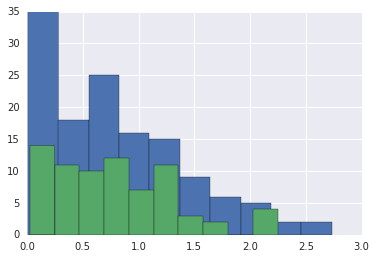

In [8]:
log_tpm_z.ix[gene_id, genotypes.columns[genotypes.sum() == 0]].abs().hist()
log_tpm_z.ix[gene_id, genotypes.columns[genotypes.sum() > 0]].abs().hist()

In [80]:
from ipyparallel import Client
parallel_client = Client()
#parallel_client = Client(profile='parallel')
dview = parallel_client[:]
print('Cluster has {} engines.'.format(len(parallel_client.ids)))

Cluster has 20 engines.


In [96]:
with dview.sync_imports():
    import cdpybio
    import cardipspy
    import numpy
    import pandas
    import os
    import scipy.stats
    import vcf

importing cdpybio on engine(s)
importing cardipspy on engine(s)
importing numpy on engine(s)
importing pandas on engine(s)
importing os on engine(s)
importing scipy.stats on engine(s)
importing vcf on engine(s)


In [91]:
%px cpb = cdpybio
%px cpy = cardipspy
%px np = numpy
%px pd = pandas
%px pyvcf = vcf

In [97]:
dview.push(dict(rare_analysis=rare_analysis, log_tpm_z=log_tpm_z, 
                gene_to_region=gene_to_region, wgs_to_rna=wgs_to_rna));

In [98]:
results = dview.map_sync(lambda x: rare_analysis(x), log_tpm_z.index[500:1500])

In [103]:
cols = ['pvalue', 'rare_mean', 'rare_median', 'rare_num',
        'no_rare_mean', 'no_rare_median', 'no_rare_num']
df = pd.DataFrame(results, columns=cols)

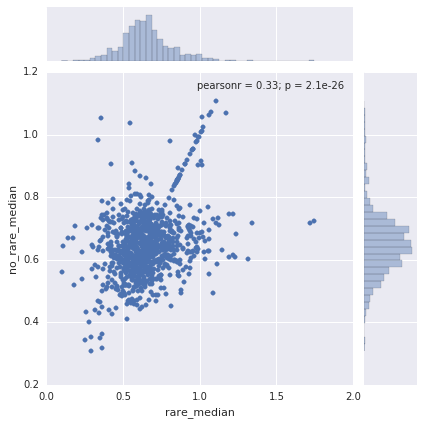

In [116]:
sns.jointplot(x='rare_median', y='no_rare_median', data=df);

In [117]:
stats.wilcoxon(df.rare_median, df.no_rare_median)

WilcoxonResult(statistic=215265.0, pvalue=0.41479965753015891)

TODO: I want to see if I can use the 1KGP intersection VCFs 
that I made to speed this stuff up a bit. I want to intersect
the variants with some functional annotations too.